In [7]:
# Importer les bibliothèques nécessaires
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error
import shap
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV

# Charger les données
df = pd.read_csv('~/Data/2.Projets/BankMarketing/data/BankFull.csv', sep=";")

# Conversion des variables catégoriques en numériques
le = LabelEncoder()
for column in df.select_dtypes(include=['object']).columns:
    df[column] = le.fit_transform(df[column])

# Traitement des données manquantes
df.fillna(df.mean(), inplace=True)

data_ml = df.drop(columns=['y'])
y = df['y']
# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(data_ml, y, test_size=0.2, random_state=42)

# Définir le pipeline avec GridSearch ou RandomizedSearch

def algorithm_pipeline(X_train, X_test, y_train, y_test, model, param_grid, cv=3):
    """
    Pipeline pour optimiser un modèle avec RandomizedSearch et calculer les prédictions.
    """
    # RandomizedSearch pour hyperparamètres
    randomized_search = RandomizedSearchCV(estimator=model,
                                           param_distributions=param_grid,
                                           scoring='neg_mean_squared_error',
                                           n_iter=50, cv=cv, verbose=2, n_jobs=-1, random_state=42)
    randomized_search.fit(X_train, y_train)
    
    # Meilleur modèle
    best_model = randomized_search.best_estimator_
    
    # Prédictions sur l'ensemble de test
    y_pred = best_model.predict(X_test)
    
    # Calculer le score quadratique moyen
    mse = mean_squared_error(y_test, y_pred)
    print(f"Mean Squared Error: {mse}")
    
    return best_model, y_pred

# Hyperparamètres pour XGBoost
param_dist = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Initialiser le modèle XGBoost
xgb_model = xgb.XGBClassifier(random_state=42)

# Appliquer le pipeline
best_model, y_pred = algorithm_pipeline(X_train, X_test, y_train, y_test, xgb_model, param_dist, cv=5)

# Afficher le rapport de classification
print("Classification Report:\n", classification_report(y_test, y_pred))

# Crosstab pour résultats
display(pd.crosstab(y_test, y_pred, rownames=['Classes réelles'], colnames=['Classes prédites']))

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Mean Squared Error: 0.09277894504036271
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.97      0.95      7952
           1       0.66      0.47      0.55      1091

    accuracy                           0.91      9043
   macro avg       0.80      0.72      0.75      9043
weighted avg       0.90      0.91      0.90      9043



Classes prédites,0,1
Classes réelles,,
0,7689,263
1,576,515


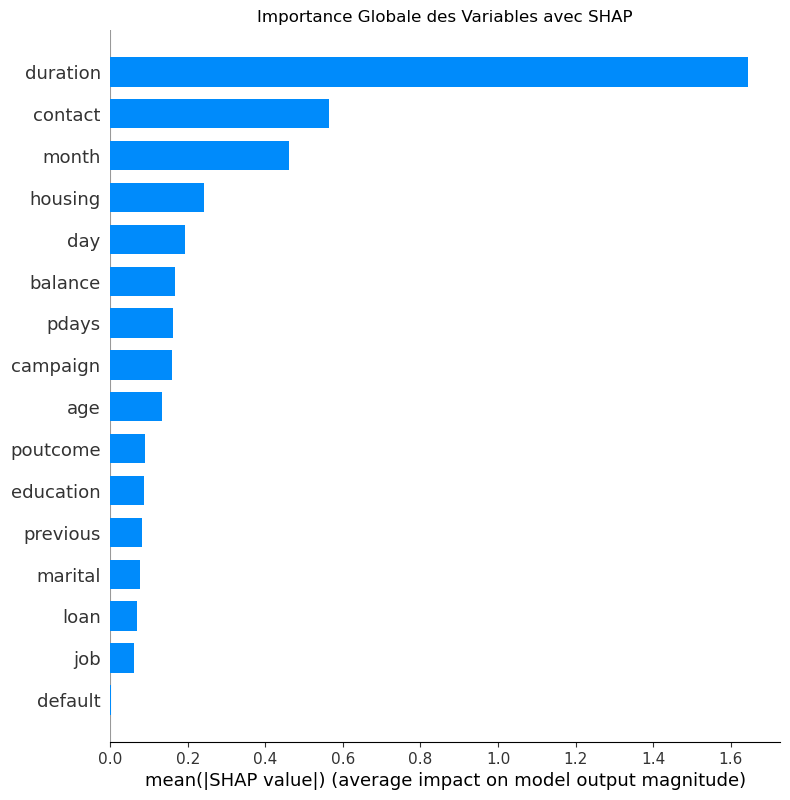

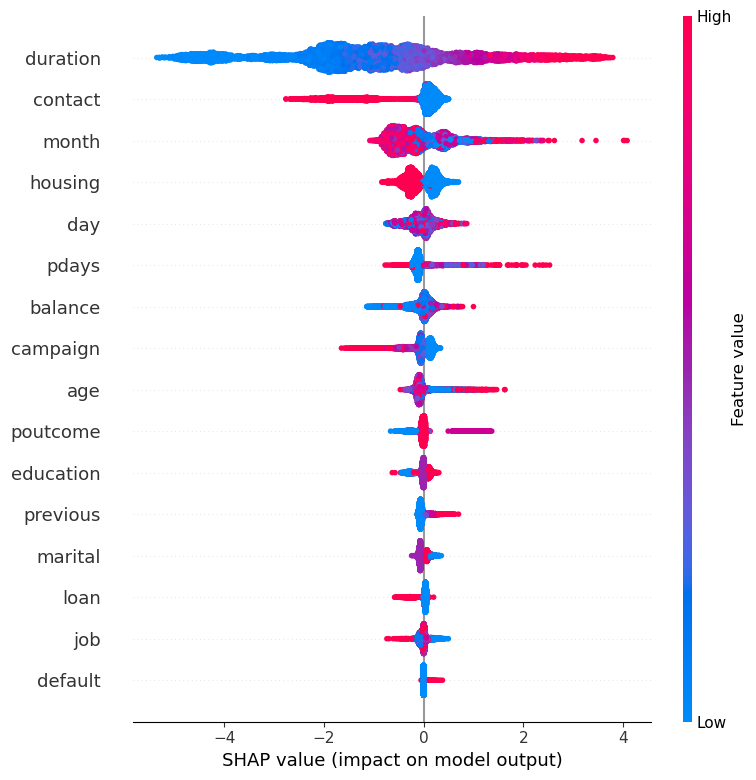

ValueError: visualize() can only display Explanation objects (or arrays of them)!

In [8]:
# Utilisation de SHAP pour l'interprétabilité
def plot_shap_summary(model, X_train):
    """
    Génère un graphique SHAP pour l'importance globale des variables.
    """
    # Calculer les valeurs SHAP
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_train)

    # Générer le graphique récapitulatif
    shap.summary_plot(shap_values, X_train, plot_type="bar", show=False)
    plt.title('Importance Globale des Variables avec SHAP')
    plt.show()

# Appel de la fonction SHAP
plot_shap_summary(best_model, X_train)

# Comparatif variables
explainer = shap.Explainer(best_model)
shap_values = explainer(X_test)
# Summary Plot
shap.summary_plot(shap_values, X_test)